# Setup

In [71]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
path = os.path.abspath('')
path = path + "/engineered_data_250ms_window80_step8.csv"
df = pd.read_csv(path)

print("Shape of DataFrame:", df.shape, "and number of features after deleting base columns:", len(df.drop(["Window", "Participant", "Run", "Path"], axis=1).columns))

Shape of DataFrame: (1306, 226) and number of features after deleting base columns: 222


In [73]:
df = df.fillna(0)

# Preprocessing data 
The goal here is to ensure that the originally engineered data set is used with the 226 columns that we developed. I wanted to create a dataset that can be easily truncated later on. In order to do that I look at the whole dataset first. I will check for shape and ensure all are numerical values. A test and training set are created. Afterwards I have been trying out a little bit of robustscaler to ensure all the data is normalized properly before feeding it to an LSTM, which benefits from quicker convergence if data is normalized already. 

In [74]:
#cleaning the data set further
# Replace string values with numerical values for easier processing in models
df.dropna(inplace=True)
df['Participant'] = df['Participant'].replace({'Dany': 0, 'Felix': 1, 'Julian': 2, 'Mark': 3, 'Martin': 4, 'Michele': 5, 'Paul': 6}) # for participants column
df['Path'] = df['Path'].replace({'straight': 0, 'circle': 1}) #for path column
#differentiate runs for later group by
X_Train = df[df['Run'] < 4].copy()
X_Test = df[df['Run'] == 4].copy()
#Change run here
for i in range(1,5):
    X_Train.loc[(X_Train['Path'] == 1) & (X_Train['Run'] == i), 'Run'] = i + 4
    X_Test.loc[(X_Test['Path'] == 1) & (X_Test['Run'] == i), 'Run'] = i + 4
#create train/test set
#should maybe do random runs in the future


# Extracting targets
Y_Train = X_Train.pop('Participant')
Y_Test = X_Test.pop('Participant')

# Verifying the final shapes and content of datasets
print("X_Train shape:", X_Train.shape)
print("X_Test shape:", X_Test.shape)
print("Y_Train shape:", Y_Train.shape)
print("Y_Test shape:", Y_Test.shape)

#Display a few rows to confirm correct data setup
print(X_Train['Path'].sample(3))
print(X_Test['Path'].sample(3))

# In order to solve the NaN issue, i try to locate the values
print("NaN in X_Train:", X_Train.isnull().sum().sum())
print("NaN in Y_Train:", Y_Train.isnull().sum().sum())
print("NaN in X_Test:", X_Test.isnull().sum().sum())

# If you'd like to see an example of where the NaN is located, uncomment below. 
# # Find rows with NaN values in X_Train
# nan_rows_X_Train = X_Train[X_Train.isnull().any(axis=1)]
# print("Rows with NaN values in X_Train:")
# print(nan_rows_X_Train)


# # Find rows with NaN values in X_Test
# nan_rows_X_Test = X_Test[X_Test.isnull().any(axis=1)]
# print("Rows with NaN values in X_Test:")
# print(nan_rows_X_Test)

# Print the number of unique rows that have NaN in X_Train and X_Test
# print("Number of unique rows with NaN in X_Train:", nan_rows_X_Train.shape[0])
# print("Number of unique rows with NaN in X_Test:", nan_rows_X_Test.shape[0])

# In order to solve the NaN issue in the SVM I will drop the the NaN values
# Remove rows with NaN values from X_Train and X_Test
X_Train_cleaned = X_Train.dropna()
X_Test_cleaned = X_Test.dropna()

# Ensure the target variables are aligned
Y_Train_cleaned = Y_Train[X_Train_cleaned.index]
Y_Test_cleaned = Y_Test[X_Test_cleaned.index]

# Ensure Y_Train_cleaned and Y_Test_cleaned is of integer type
Y_Train_cleaned = Y_Train_cleaned.astype(int)
Y_Test_cleaned = Y_Test_cleaned.astype(int)
X_Train['Path'].to_string()

X_Train shape: (1019, 225)
X_Test shape: (287, 225)
Y_Train shape: (1019,)
Y_Test shape: (287,)
891    0
414    0
868    0
Name: Path, dtype: int64
592     0
1075    0
651     1
Name: Path, dtype: int64
NaN in X_Train: 0
NaN in Y_Train: 0
NaN in X_Test: 0


/tmp/ipykernel_4013/1950555561.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Participant'] = df['Participant'].replace({'Dany': 0, 'Felix': 1, 'Julian': 2, 'Mark': 3, 'Martin': 4, 'Michele': 5, 'Paul': 6}) # for participants column
/tmp/ipykernel_4013/1950555561.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Path'] = df['Path'].replace({'straight': 0, 'circle': 1}) #for path column


'0       1\n1       1\n2       1\n3       1\n4       1\n5       1\n6       1\n7       1\n8       1\n9       1\n10      1\n11      1\n12      1\n13      1\n14      1\n15      1\n16      1\n17      1\n18      1\n19      1\n20      1\n21      1\n22      1\n23      1\n24      1\n25      1\n26      1\n27      1\n28      1\n29      1\n30      1\n31      1\n32      1\n33      1\n34      1\n35      1\n36      1\n37      1\n38      1\n39      1\n40      1\n41      1\n42      1\n43      1\n44      1\n45      1\n46      1\n47      1\n48      1\n49      1\n50      1\n51      1\n52      1\n53      1\n54      1\n55      1\n56      1\n57      1\n58      1\n59      1\n60      1\n61      1\n62      1\n63      1\n64      1\n65      1\n66      1\n67      1\n68      1\n69      1\n70      1\n71      1\n72      1\n73      1\n74      1\n75      1\n76      1\n77      1\n78      1\n79      1\n80      1\n81      1\n82      1\n83      1\n84      1\n85      1\n86      1\n87      1\n88      1\n89      1\n90      1

# Normalizing
I have not completed this step, could you please pick this up and ensure the data is normalized?
Data of the first four columns are not to be normalized and need to remain the same, the rest of the data is sensor data and should be normalized I haven't figured it out yet. 

In [75]:
# # Define a ColumnTransformer that will apply RobustScaler to all columns except the first four
# # The first four columns are passed through without scaling using 'passthrough'
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', RobustScaler(), df.columns[4:]),  # Apply RobustScaler to columns from the 5th to the last
#         ('pass', 'passthrough', df.columns[:4])   # Pass through the first four columns without scaling
#     ],
#     remainder='drop'  # Drop columns not specified explicitly (none in this case)
# )
# 
# # Fit and transform the data using ColumnTransformer
# df_scaled = pd.DataFrame(preprocessor.fit_transform(df), columns=df.columns)
# 
# # Print or analyze the transformed DataFrame
# print(df_scaled.head())

## Locating NaN values and ensuring proper deletion
Here I have attempted to get a good understtanding of where the NaN data is located in our dataset. 
Afterwards I will do a detailed analysis of the columns and rows specifically. I go through some cycles and different approaches in deleting the NaN values. I started with deleting the columns with a 100% NaN but later made a graph that shows the cutoff point in the data I will actually use. If you run the code and just read the comments and graphs you should be able to understand the gist of it. 

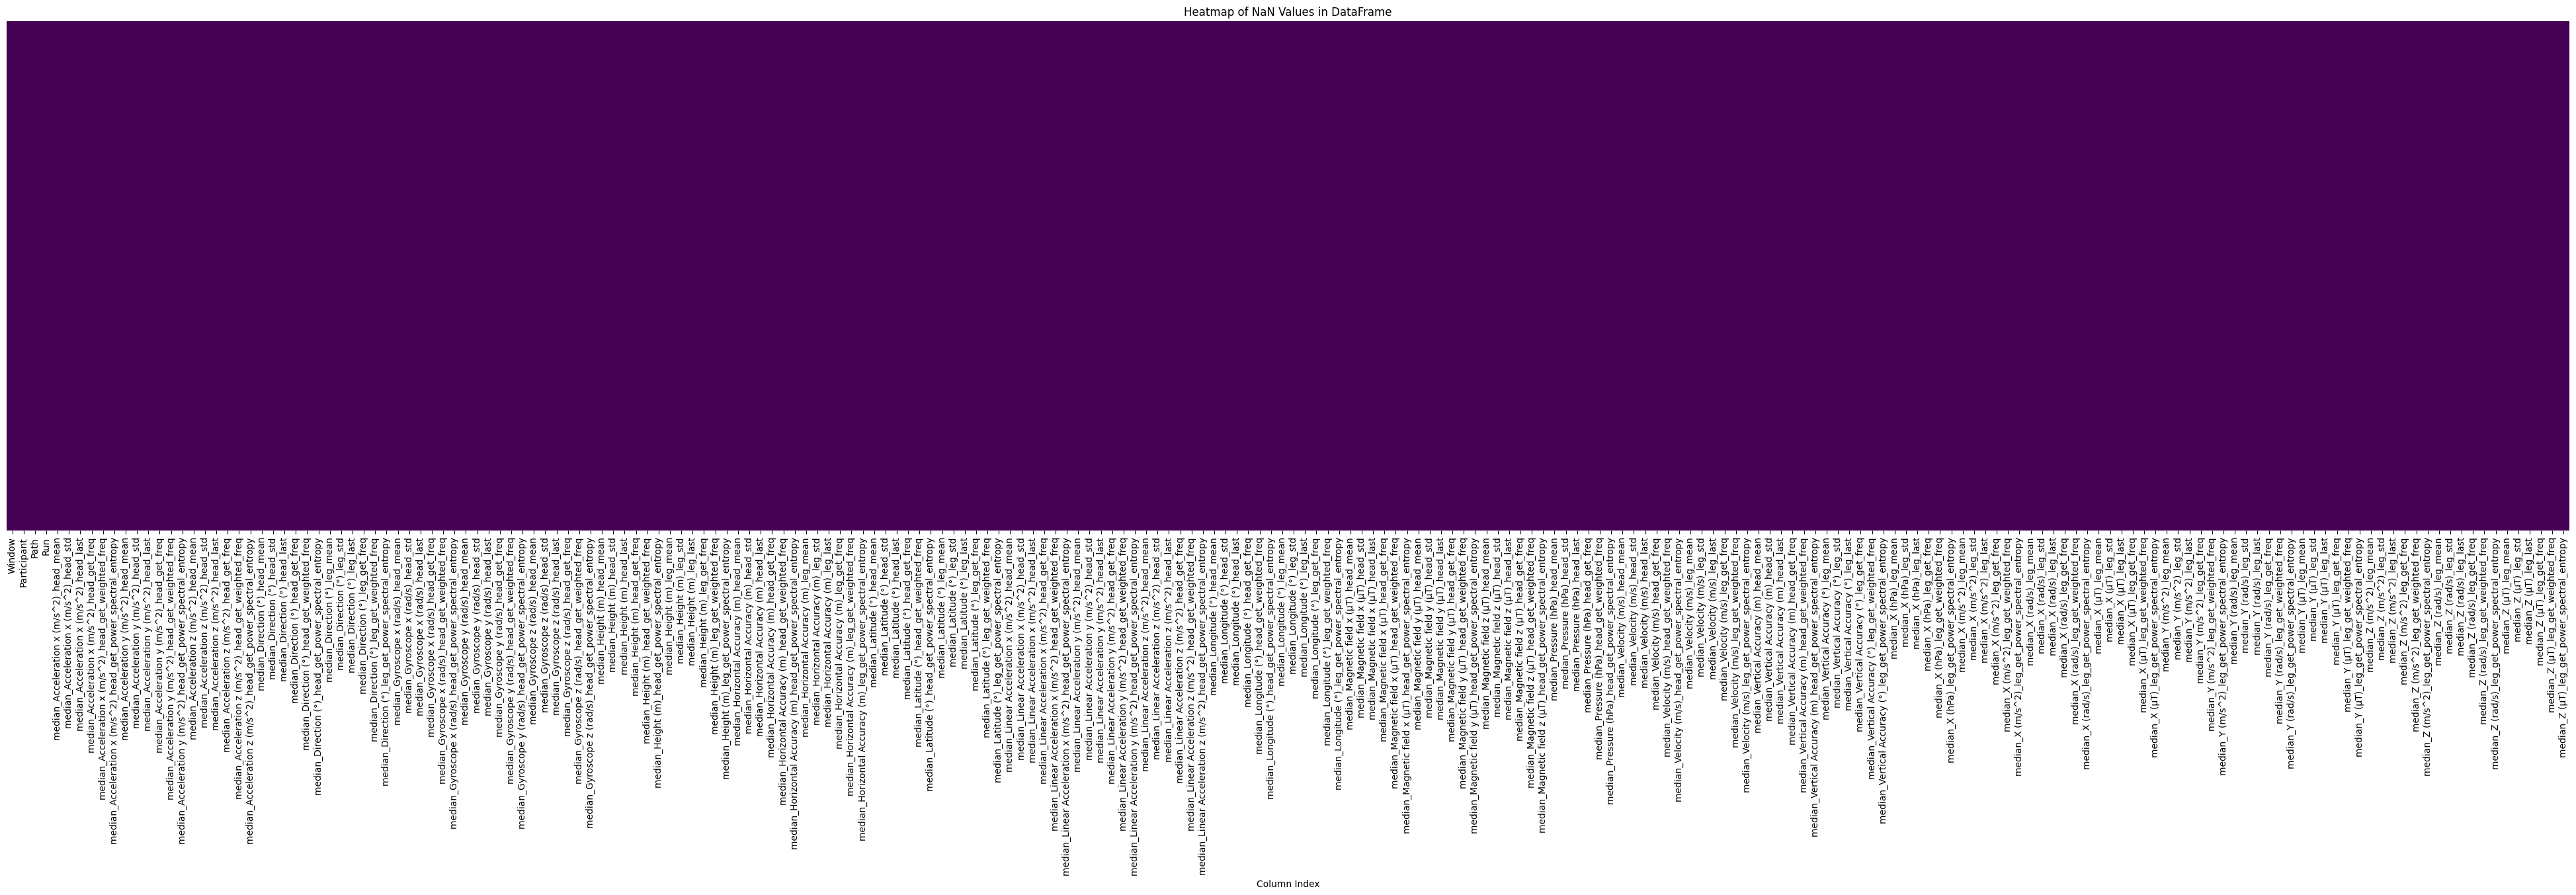

In [76]:
# Create a binary DataFrame showing where NaNs are located
nan_map = df.isnull()

# Create a heatmap
plt.figure(figsize=(50, 10))  # Adjust size as needed to display all columns
sns.heatmap(nan_map, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of NaN Values in DataFrame')
plt.xlabel('Column Index')
plt.show()

In [77]:
# Check how many columns have 100 percent NaN
columns_to_drop = df.columns[df.isnull().mean() == 1]
print("Numbers of columns that have 100% NaN:", len(columns_to_drop))
#drop NaN columns
df_cleaned = df.drop(columns=df.columns[df.isnull().mean() == 1])

Numbers of columns that have 100% NaN: 0


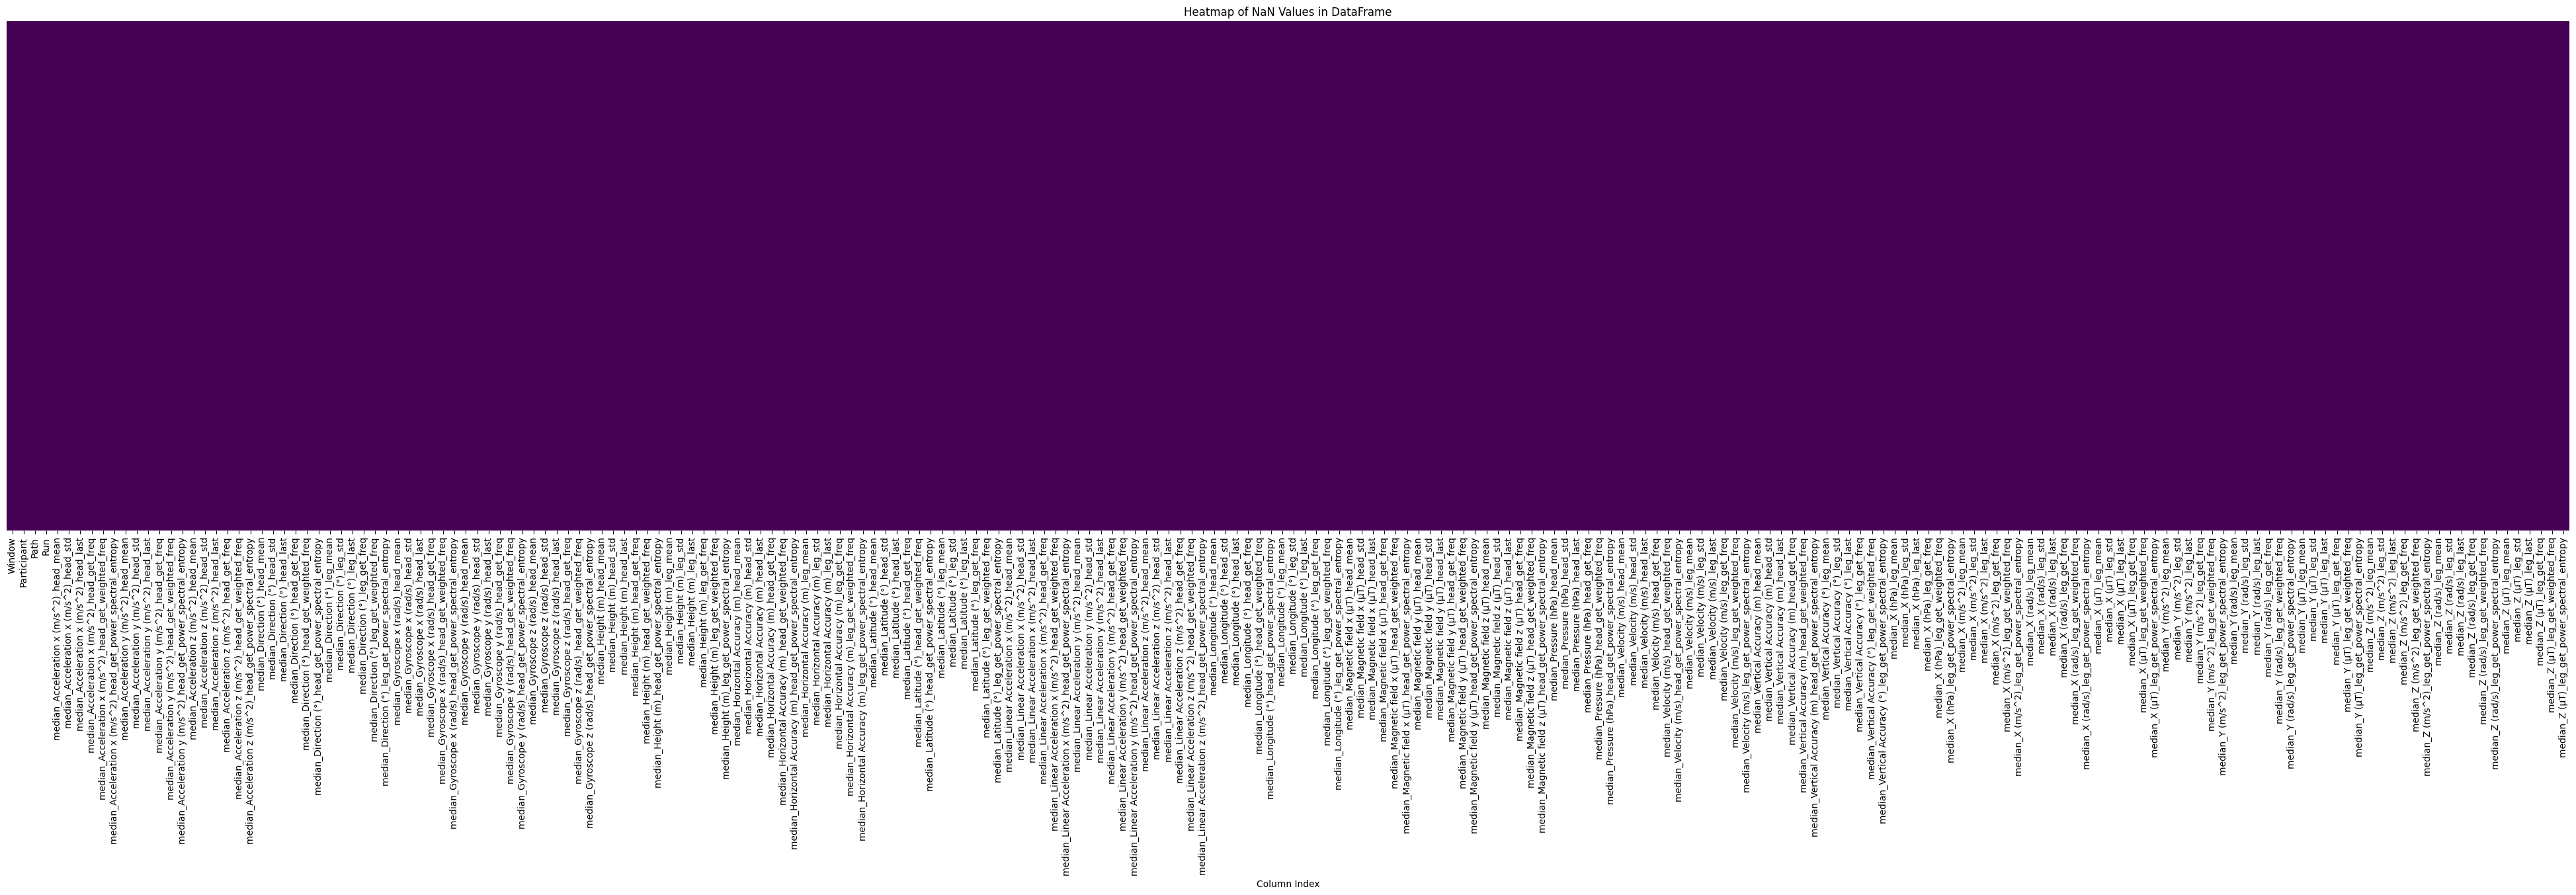

In [78]:
# create an updated map of the NaN
nan_map = df_cleaned.isnull()

# Create a heatmap
plt.figure(figsize=(50, 10))  # Adjust size as needed to display all columns
sns.heatmap(nan_map, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of NaN Values in DataFrame')
plt.xlabel('Column Index')
plt.show()

### This area is used to more formally find a good cutoff point for the NaN values. 
The columns that have more than 20% NaN values can be deleted without losing all too many features. The rest of the missing data should be imputed. Probably it is best to use interpolation for that. 

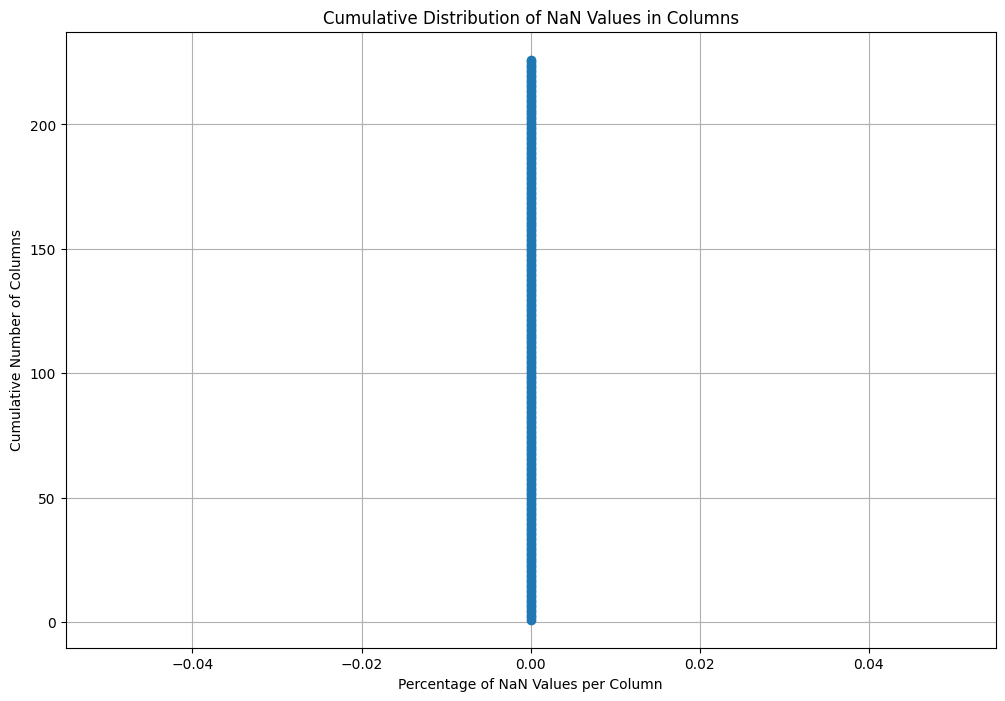

In [79]:
# Calculate the percentage of NaN values for each column
perc_NaN_per_column = df.isnull().mean() * 100

# Sort the percentages
sorted_perc = np.sort(perc_NaN_per_column)

# Calculate the cumulative count of columns
cumulative_counts = np.arange(1, len(sorted_perc) + 1)

# Plot the cumulative distribution
plt.figure(figsize=(12, 8))
plt.plot(sorted_perc, cumulative_counts, marker='o', linestyle='-')
plt.xlabel('Percentage of NaN Values per Column')
plt.ylabel('Cumulative Number of Columns')
plt.title('Cumulative Distribution of NaN Values in Columns')
plt.grid(True)
plt.show()

### Row NaN deletion
It is probably a good idea to delete the rows that have more than 50 or 55% of NaN and impute the rest using interpolation. The reason I give this amount is because deleting at the 22% mark would result in about 15-20% loss of data, which I find a bit too much for the rows. Especially if we will impute some missing data I think it makes sense to not delete all too many rows. 

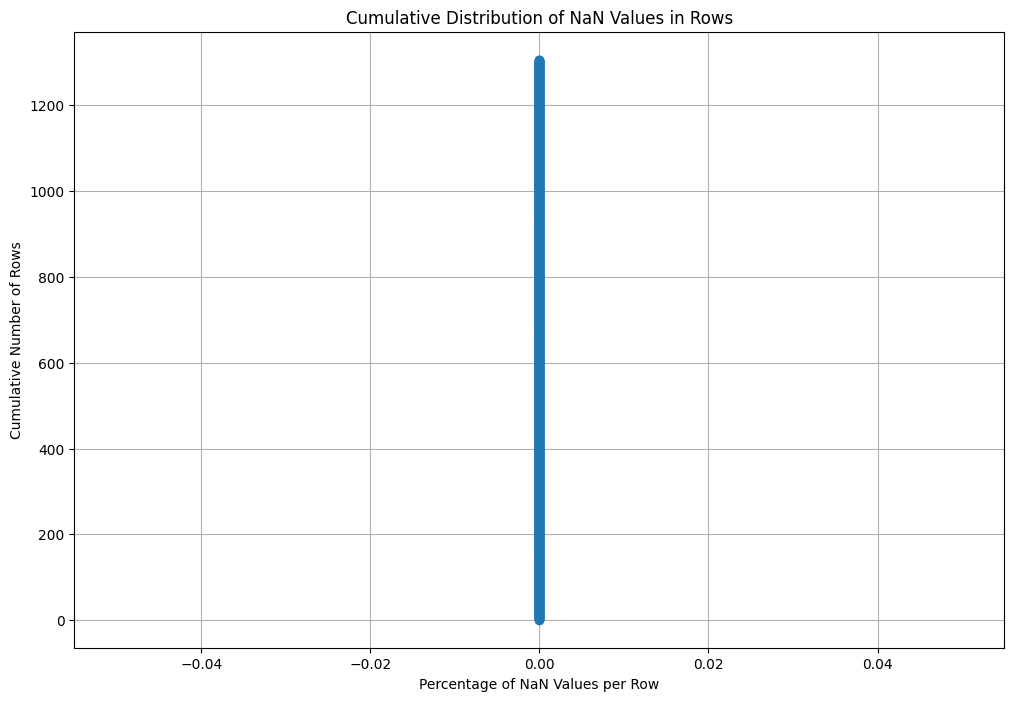

In [80]:
# Calculate the percentage of NaN values for each row
perc_NaN_per_row = df.isnull().mean(axis=1) * 100

# Sort the percentages
sorted_perc = np.sort(perc_NaN_per_row)

# Calculate the cumulative count of rows
cumulative_counts = np.arange(1, len(sorted_perc) + 1)

# Plot the cumulative distribution
plt.figure(figsize=(12, 8))
plt.plot(sorted_perc, cumulative_counts, marker='o', linestyle='-')
plt.xlabel('Percentage of NaN Values per Row')
plt.ylabel('Cumulative Number of Rows')
plt.title('Cumulative Distribution of NaN Values in Rows')
plt.grid(True)
plt.show()



# Next steps - TODO 
So far the data has been preprocessed for 50%. 
There needs to be some more adjustments to it. 
These are:

- Normalizing (I haven't tested this out yet)
- Deleting the columns that have more than 20% NaN values
- Deleting the rows that have more than 50 or 55% of NaN values
- Imputing the missing data using interpolation (or another suitable temporally coherent method)
- Setting up the LSTM data pipeline and feed data
- Interpret results of the model






In [81]:
# #DATA PREP FOR LSTM
# import torch
 
# from torch.utils.data import Dataset, DataLoader
# from torch.nn.utils.rnn import pad_sequence
 
# columns_to_drop = ['Path', 'Window']
# x = X_Train.drop(columns=columns_to_drop, inplace=False)
# y = Y_Train
# x['participant_id'] = y
# x_series = []
# for d1 in x.groupby('participant_id'):
#     for d2 in d1[1].groupby('Run'):
#         data = d2[1].drop(['participant_id', 'Run'], axis=1)
#         x_series.append(data.to_numpy())
 
# class PadSequenceDataset(Dataset):
#     def __init__(self, sequences, labels):
#         self.sequences = sequences
#         self.labels = labels
 
#     def __len__(self):
#         return len(self.sequences)
 
#     def __getitem__(self, idx):
#         sequence = self.sequences[idx]
#         label = self.labels[idx]
#         return torch.tensor(sequence, dtype=torch.float), torch.tensor(label, dtype=torch.long)
 
# def pad_collate(batch):
#     (xx, yy) = zip(*batch)
#     xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
#     yy_tensor = torch.stack(yy)
#     return xx_pad, yy_tensor
 
# # Assuming x_series is a list of numpy arrays and y is a list of labels
# dataset = PadSequenceDataset(x_series, y)
# dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=pad_collate)
# print(x_series)
# print(len(x_series))
# # print(len(y))
# # niter = 0
# # for x, y in dataloader:
# #     print(x.shape)
# #     print(y)
# #     if niter == 5:
# #         break
# #     niter += 1

In [86]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from sklearn.preprocessing import StandardScaler
# Assuming X_Train and Y_Train are your input DataFrames

columns_to_drop = ['Path', 'Window']
x = X_Train.drop(columns=columns_to_drop, inplace=False)
y = Y_Train

x['participant_id'] = y
x_series = []
y = []
# Verify the unique participants and runs
unique_participants = x['participant_id'].unique()
print("Unique participants:", unique_participants)

for participant_id, participant_data in x.groupby('participant_id'):
    for run, run_data in participant_data.groupby('Run'):
        data = run_data.drop(['participant_id', 'Run'], axis=1)
        x_series.append(data.to_numpy())
        # Append the participant_id to y_series
        y.append(participant_id)  # Assuming label is the participant_id, adjust if needed


# Check if x_series and y have the same length
print(f"Number of sequences: {len(x_series)}")
print(f"Number of labels: {len(y)}")

if len(x_series) != len(y):
    raise ValueError("The number of sequences and labels do not match!")



Unique participants: [0 1 2 3 4 5 6]
Number of sequences: 42
Number of labels: 42


In [87]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

# Assuming x_series and y_series are correctly prepared as lists of numpy arrays and labels
y_series = y
scaler = StandardScaler()

# Flatten x_series to fit the scaler
all_data = np.concatenate(x_series, axis=0)

# Fit the scaler on the entire dataset
scaler.fit(all_data)

# Transform each sequence
x_series_normalized = [scaler.transform(sequence) for sequence in x_series]
x_series = x_series_normalized
class PadSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return torch.tensor(sequence, dtype=torch.float), torch.tensor(label, dtype=torch.long)

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
    yy_tensor = torch.stack(yy)
    return xx_pad, yy_tensor

# Assuming x_series is a list of numpy arrays and y_series is a list of labels
dataset = PadSequenceDataset(x_series, y_series)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=pad_collate)

input_size = x_series[0].shape[1]  # Number of features
num_layers = 2
hidden_size = 256

learning_rate = 0.001
num_epochs = 50
num_classes = len(set(y_series))  # Number of unique labels

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleGRU, self).__init__()
        self.hidden_size  = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.gru(x, h0)
        #print(f"GRU output shape: {out.shape}")  # Debug print
        out = out[:, -1, :]  # Take the output from the last time step
        #print(f"Last time step GRU output shape: {out.shape}")  # Debug print
        out = self.fc1(out)
        return out

model = SimpleGRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device=device)

loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in dataloader:
        if torch.isnan(batch_x).any() or torch.isinf(batch_x).any():
            raise ValueError("Input data contains NaN or Inf values")
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)
        loss = loss_criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"At epoch: {epoch}, loss: {loss.item()}")


At epoch: 0, loss: 2.1091060638427734
At epoch: 1, loss: 1.8188035488128662
At epoch: 2, loss: 1.611088514328003
At epoch: 3, loss: 1.2913318872451782
At epoch: 4, loss: 0.581150472164154
At epoch: 5, loss: 0.6281349658966064
At epoch: 6, loss: 0.8944224119186401
At epoch: 7, loss: 0.4211481511592865
At epoch: 8, loss: 0.16427434980869293
At epoch: 9, loss: 0.6033003330230713
At epoch: 10, loss: 0.2416040599346161
At epoch: 11, loss: 0.2830013036727905
At epoch: 12, loss: 0.27719858288764954
At epoch: 13, loss: 0.12952014803886414
At epoch: 14, loss: 0.41596755385398865
At epoch: 15, loss: 0.15338847041130066
At epoch: 16, loss: 0.13391360640525818
At epoch: 17, loss: 0.015636730939149857
At epoch: 18, loss: 0.02990482933819294
At epoch: 19, loss: 0.01509079523384571
At epoch: 20, loss: 0.017801402136683464
At epoch: 21, loss: 0.011302772909402847
At epoch: 22, loss: 0.0058900113217532635
At epoch: 23, loss: 0.00890820287168026
At epoch: 24, loss: 0.0041129011660814285
At epoch: 25, lo

In [89]:

columns_to_drop = ['Path', 'Window']
x = X_Test.drop(columns=columns_to_drop, inplace=False)
y = Y_Test

x['participant_id'] = y
x_series = []
y = []
# Verify the unique participants and runs
unique_participants = x['participant_id'].unique()
print("Unique participants:", unique_participants)

for participant_id, participant_data in x.groupby('participant_id'):
    for run, run_data in participant_data.groupby('Run'):
        data = run_data.drop(['participant_id', 'Run'], axis=1)
        x_series.append(data.to_numpy())
        # Append the participant_id to y_series
        y.append(participant_id)  # Assuming label is the participant_id, adjust if needed


# Check if x_series and y have the same length
print(f"Number of sequences: {len(x_series)}")
print(f"Number of labels: {len(y)}")

if len(x_series) != len(y):
    raise ValueError("The number of sequences and labels do not match!")

y_series = y
scaler = StandardScaler()

# Flatten x_series to fit the scaler
all_data = np.concatenate(x_series, axis=0)

# Fit the scaler on the entire dataset
scaler.fit(all_data)

# Transform each sequence
x_series_normalized = [scaler.transform(sequence) for sequence in x_series]
x_series = x_series_normalized

test_dataset = PadSequenceDataset(x_series, y_series)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=pad_collate)

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, test_dataloader, device)
print(f'Test Accuracy: {test_accuracy:.2f}%')


Unique participants: [0 1 2 3 4 5 6]
Number of sequences: 13
Number of labels: 13
